In [7]:
import ipykernel, os
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import time

In [265]:
from prophet_strat import *

In [16]:
stock_number = 12
data_to_750 = pd.read_csv('data/prices0to750.csv')
data_to_750.columns = [int(i) for i in data_to_750.columns]
data_to_750[1]

0      71.65
1      72.10
2      72.35
3      72.51
4      71.99
       ...  
745    63.28
746    63.34
747    63.23
748    63.12
749    63.32
Name: 1, Length: 750, dtype: float64

In [28]:
stock_number = 12
data_to_750 = pd.read_csv(r'data/prices0to750.csv')
data_to_750.columns = [int(i) for i in data_to_750.columns]
training_data = data_to_750[stock_number]
time_data = pd.date_range(start='1/1/2010', periods=len(training_data), freq='D')
training_data = pd.DataFrame({'ds': time_data, 'y': training_data})

In [38]:
training_data_250 = training_data[:600].copy()

# 50 days ahead seems like the sweet spot for prediction - far ahead but seems accurate enough.

00:16:30 - cmdstanpy - INFO - Chain [1] start processing
00:16:31 - cmdstanpy - INFO - Chain [1] done processing


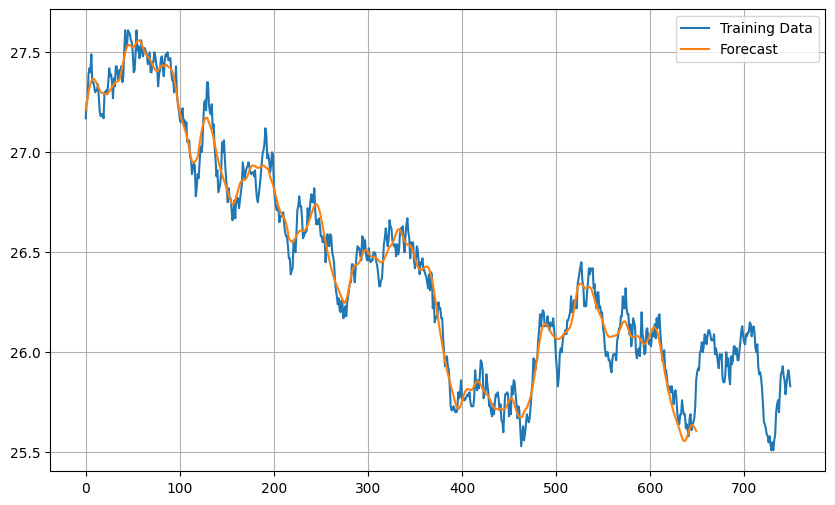

In [40]:
model = Prophet(
    growth='linear',
    seasonality_mode='multiplicative',
    seasonality_prior_scale=10,
    changepoint_prior_scale=0.05,
    n_changepoints=100,
    changepoint_range=0.9,
    weekly_seasonality=False,
    daily_seasonality=False,
    yearly_seasonality=False
)
model.add_seasonality(name='monthly', period=120, fourier_order=10, prior_scale=0.02)
model.add_seasonality(name='weekly', period=60, fourier_order=3)
model.fit(training_data_250)
future = model.make_future_dataframe(periods=50)
forecast = model.predict(future)

plt.figure(figsize=(10, 6))
plt.plot(training_data.index, training_data['y'], label='Training Data')
plt.plot(forecast.index, forecast['yhat'], label='Forecast')
plt.plot


plt.grid()
plt.legend()
plt.show()


In [36]:
# Rapid prototype here
position = np.zeros(50)
data_with_date = pd.DataFrame()
all_predictions = pd.DataFrame() # Includes data up till now and predictions for the next 10 days
upper_bounds = pd.Series(50)
lower_bounds = pd.Series(50)
date_start = '2021-01-01'

def getPosition(price_so_far):
    nt, nins = price_so_far.shape
    global position, data_with_date, all_predictions, date_start, upper_bounds, lower_bounds
    data_with_date = price_so_far.copy()
    data_with_date.columns =  [int(i) for i in range(nins)]
    data_with_date['ds'] = pd.date_range(date_start, periods=len(data_with_date), freq='D')

    # Parameters
    predict_cycle = 10 # Number of days before retraining the model

    # Stage 1: Train the model and predict when necessary
    if len(price_so_far) % predict_cycle == 1: # TODO: tune this for runtime optimization
        for i in range(nins):
            train = data_with_date[['ds', i]].copy()
            train.columns = ['ds', 'y']
            model = Prophet(
                changepoint_range=0.9,
            )
            model.add_seasonality(name='monthly', period=250, fourier_order=100, prior_scale=10)
            model.add_seasonality(name='weekly', period=100, fourier_order=100, prior_scale=10)
            
            model.fit(train)
            future = model.make_future_dataframe(periods=10)
            forecast = model.predict(future)
            all_predictions[i] = forecast['yhat']
            # TODO: add code to update upper_bounds and lower_bounds
    
    else: # Update data with current values, TODO raise flag if anomaly detected
        all_predictions = pd.concat([data_with_date, all_predictions.iloc[nt:]], axis = 'rows')

    for i in range(50):
        avg = all_predictions[i].mean()
        if data_with_date[i].iloc[-1] > avg:
            position[i] = 1
        else:
            position[i] = -1

    # for i in range(50):
    #     train = data_with_date[i, 'ds']
    #     train.columns = ['y', 'ds']
    #     model = Prophet()
    #     model.fit(train)
    #     future = model.make_future_dataframe(periods=10)
    #     forecast = model.predict(future)
    #     all_predictions[i] = forecast['yhat']
    return position


In [174]:
# Testing
getPosition(day1)

13:38:24 - cmdstanpy - INFO - Chain [1] start processing
13:38:25 - cmdstanpy - INFO - Chain [1] done processing
13:38:25 - cmdstanpy - INFO - Chain [1] start processing
13:38:26 - cmdstanpy - INFO - Chain [1] done processing
13:38:26 - cmdstanpy - INFO - Chain [1] start processing
13:38:26 - cmdstanpy - INFO - Chain [1] done processing
13:38:27 - cmdstanpy - INFO - Chain [1] start processing
13:38:27 - cmdstanpy - INFO - Chain [1] done processing
13:38:28 - cmdstanpy - INFO - Chain [1] start processing
13:38:28 - cmdstanpy - INFO - Chain [1] done processing
13:38:28 - cmdstanpy - INFO - Chain [1] start processing
13:38:29 - cmdstanpy - INFO - Chain [1] done processing
13:38:29 - cmdstanpy - INFO - Chain [1] start processing
13:38:29 - cmdstanpy - INFO - Chain [1] done processing
13:38:30 - cmdstanpy - INFO - Chain [1] start processing
13:38:30 - cmdstanpy - INFO - Chain [1] done processing
13:38:31 - cmdstanpy - INFO - Chain [1] start processing
13:38:32 - cmdstanpy - INFO - Chain [1]

array([ 1., -1., -1., -1.,  1., -1., -1.,  1., -1., -1., -1., -1., -1.,
        1., -1.,  1., -1., -1., -1.,  1.,  1., -1., -1., -1., -1.,  1.,
        1., -1., -1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1.,
        1., -1.,  1., -1., -1., -1., -1., -1., -1.,  1., -1.])

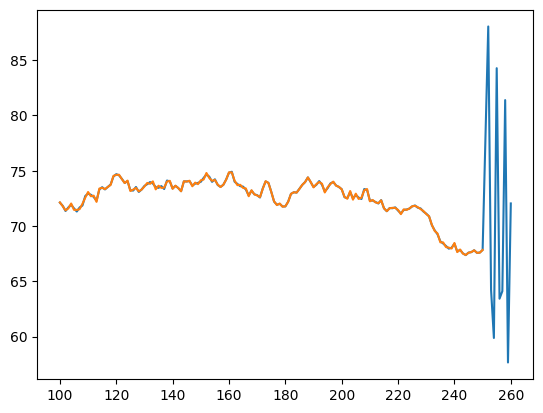

In [175]:
plt.plot(all_predictions[100:][1])
plt.plot(data_with_date[100:][1])

plt.show()

In [129]:
day1 = full_data.iloc[0:251, 0:50].copy()
day2 = full_data.iloc[0:252, 0:50].copy()
day3 = full_data.iloc[0:253, 0:50].copy()
day4 = full_data.iloc[0:254, 0:50].copy()
day5 = full_data.iloc[0:255, 0:50].copy()
day6 = full_data.iloc[0:256, 0:50].copy()
day7 = full_data.iloc[0:257, 0:50].copy()
day8 = full_data.iloc[0:258, 0:50].copy()
day9 = full_data.iloc[0:259, 0:50].copy()
day10 = full_data.iloc[0:260, 0:50].copy()
day11 = full_data.iloc[0:261, 0:50].copy()
day12 = full_data.iloc[0:262, 0:50].copy()

In [58]:
nInst = 50
currentPos = np.zeros(nInst)

training_data = pd.read_csv('data/prices0to250.csv')
full_data = pd.read_csv('data/prices0to500.csv')
training_data.columns = [int(col) for col in training_data.columns]
full_data.columns = [int(col) for col in full_data.columns]

data_to_now_250 = training_data.copy()

# Simulated date for prophet model
start_date = '2023-07-01'
date_range = pd.date_range(start=start_date, periods=250, freq='D')
data_to_now_250['ds'] = date_range

date_range = pd.date_range(start=start_date, periods=500, freq='D')
full_data['ds'] = date_range

In [231]:
monthly_period = [130]
weekly_period = [10]

monthly_fourier_order = [100]
weekly_fourier_order = [50]

monthly_prior_scale = [5]
weekly_prior_scale = [5]

14:42:35 - cmdstanpy - INFO - Chain [1] start processing
14:42:35 - cmdstanpy - INFO - Chain [1] done processing


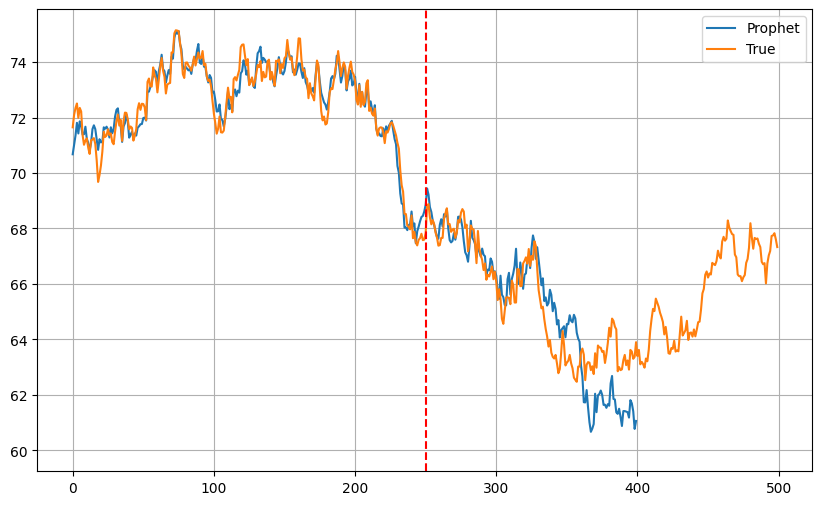

In [262]:
# Test prediction on all 500
stock_num = 1
training_data = full_data[['ds', stock_num]]
training_data = training_data.iloc[:300]
training_data.columns = ['ds', 'y']
model = Prophet(
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.01,
    seasonality_prior_scale=7,
    n_changepoints=120,
    changepoint_range=1,
)


model.add_seasonality(name='monthly', period=130, fourier_order=100, prior_scale=5)
model.add_seasonality(name='weekly', period=100, fourier_order=150, prior_scale=5)

plt.figure(figsize=(10, 6))

model.fit(training_data)
future = model.make_future_dataframe(periods=100)
forecast_prophet = model.predict(future)
plt.plot(forecast_prophet['yhat'], label='Prophet')
plt.plot(full_data[stock_num], label='True')
plt.axline((250, min(forecast_prophet['yhat'])), (250, 60), color='r', linestyle='--')
plt.legend()
plt.grid()
plt.show()

In [246]:
from prophet.__version__ import __version__
__version__

'1.1.5'

In [88]:
data_now_and_ahead = pd.DataFrame(columns=[[i for i in range(50)], 'ds']) # Should this have date information?

In [95]:
data_now_and_ahead = pd.DataFrame(columns=[[i for i in range(50)]]) # Should this have date information?

In [108]:
nums = [int(i) for i in range(50)]+['ds']
nums

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 'ds']

None


<Axes: >

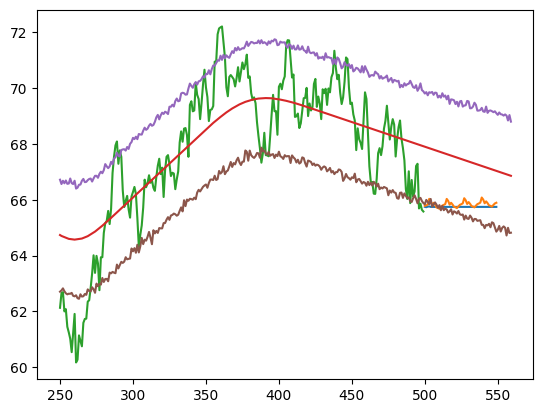

In [59]:
# Test ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# ARIMA
model = ARIMA(training_data['y'], order=(5, 1, 0))
model_fit = model.fit()
forecast = model_fit.forecast(steps=50)
forecast.plot()

# SARIMA
model = SARIMAX(training_data['y'], order=(5, 1, 0), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()
forecast = model_fit.forecast(steps=50)
forecast.plot()

training_data['y'][250:].plot()
forecast_prophet['yhat'][250:560].plot()
forecast_prophet['yhat_upper'][250:560].plot()
forecast_prophet['yhat_lower'][250:560].plot()

<Axes: >

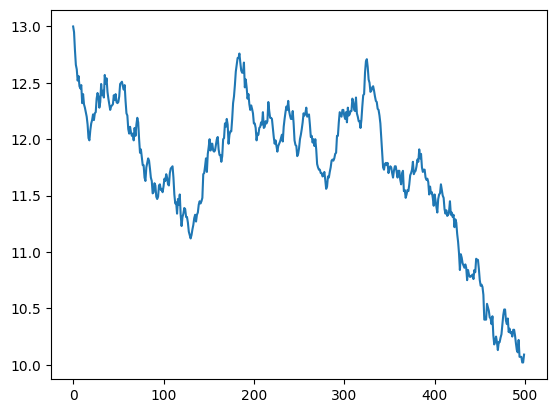

In [10]:
full_data[5].plot()

In [5]:
def getPositionWithProphet(prcSoFar):
    '''
        [WORK IN PROGRESS]
        An attempt at a trading algorithm using the Prophet library.
        1. Grab existing data
        2. Iterate through each stock and fit the model
        3. Predict, number of days ahead proportional to the number of days of data 
        4. Use the prediction to determine the position
    '''
    global currentPos, training_data, data_now_and_forecast
    prediction = pd.DataFrame()
    (nins, nt) = prcSoFar.shape # nins is the number of instruments and nt is the number of days of data
    # Parameters for prophet
    ndays = nt//10 # Number of days to predict, stay at around 10%

    
    # Parameters for the trading algorithm
    

    
    # Add one row to the prediction dataframe, with date


    
    for i in range(nins):
        # Create a dataframe with the date and price
        df = pd.DataFrame({'ds': prediction['ds'], 'y': prediction[i]})
        # Fit the model
        model = Prophet() # TODO adjust parameters
        model.fit(df)
        # Add predictions to the prediction dataframe
        future = model.make_future_dataframe(periods=ndays)
        forecast = model.predict(future)
        # Saving it to the prediction dataframe
        

    # Begin determining position
    for i in range(nins):
        ...
    return currentPos

In [6]:
prediction_all = pd.DataFrame()

for i in range(50):
    # Create a dataframe with the date and price
    df = pd.DataFrame({'ds': data_to_now_250['ds'], 'y': data_to_now_250[i]})
    # Fit the model
    model = Prophet() # TODO adjust parameters
    model.fit(df)
    # Add predictions to the prediction dataframe
    future = model.make_future_dataframe(periods=25)
    prediction = model.predict(future)
    prediction_all[i] = prediction['yhat']
    # Scoring algorithm
    # Take the first and last value of the prediction, calculate difference
    # That would be the slope of each
    # pct_up = Likelihood of going down would be a*yhat + b*lower_bound
    # pct_down = Likelihood of going up would be a*yhat + b*upper_bound
    # If abs(pct_up - pct_down) < threshold, then don't trade
    # Else, short or long accordingly.

    # Look at how tight the bounds are, indicating how confident the model is
    # If the bounds are tight, then trade more
    # If the bounds are loose, then trade less
        # Maybe ratio (upper_bound_beginning-lower_bound_beginning)/(upper_bound_end-lower_bound_end)
    

    # Future direction: look at longer term predictions and take them into account.   
    
# Appending it to the data dataframe


18:18:18 - cmdstanpy - INFO - Chain [1] start processing
18:18:18 - cmdstanpy - INFO - Chain [1] done processing
18:18:18 - cmdstanpy - INFO - Chain [1] start processing
18:18:18 - cmdstanpy - INFO - Chain [1] done processing
18:18:18 - cmdstanpy - INFO - Chain [1] start processing
18:18:18 - cmdstanpy - INFO - Chain [1] done processing
18:18:18 - cmdstanpy - INFO - Chain [1] start processing
18:18:18 - cmdstanpy - INFO - Chain [1] done processing
18:18:19 - cmdstanpy - INFO - Chain [1] start processing
18:18:19 - cmdstanpy - INFO - Chain [1] done processing
18:18:19 - cmdstanpy - INFO - Chain [1] start processing
18:18:19 - cmdstanpy - INFO - Chain [1] done processing
18:18:19 - cmdstanpy - INFO - Chain [1] start processing
18:18:19 - cmdstanpy - INFO - Chain [1] done processing
18:18:19 - cmdstanpy - INFO - Chain [1] start processing
18:18:19 - cmdstanpy - INFO - Chain [1] done processing
18:18:20 - cmdstanpy - INFO - Chain [1] start processing
18:18:20 - cmdstanpy - INFO - Chain [1]

In [8]:
prediction_all

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,13.620103,71.926761,48.476693,50.567128,51.777613,12.734213,18.985956,47.854960,69.689295,49.337549,...,32.540204,56.322447,14.330773,58.837353,37.246519,52.553617,49.689945,36.465197,49.397043,55.767983
1,13.631043,71.797075,48.461014,50.571639,51.840450,12.673731,18.972179,47.851203,69.685651,49.416981,...,32.541837,56.339787,14.315286,58.865825,37.268971,52.518453,49.713320,36.457727,49.350125,55.727560
2,13.653390,71.763096,48.441811,50.570899,51.903405,12.654437,18.958260,47.886513,69.676040,49.447211,...,32.578340,56.163916,14.297194,59.066311,37.330092,52.482164,49.793362,36.431542,49.249925,55.761428
3,13.670781,71.652077,48.438039,50.568754,51.938485,12.615169,18.952343,47.855701,69.646433,49.606418,...,32.642948,56.114313,14.298314,59.123005,37.307627,52.412583,49.831655,36.417078,49.166501,55.769444
4,13.667077,71.642902,48.431710,50.566630,51.961936,12.589398,18.945599,47.832113,69.659825,49.646542,...,32.707601,56.042426,14.296690,59.354684,37.344854,52.388632,49.979430,36.412897,49.066406,55.754598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,15.116141,65.048689,46.590954,47.082885,56.225015,11.899659,18.241379,47.732890,66.921413,49.733213,...,31.143375,69.590628,12.333044,60.033352,36.209969,51.907923,51.551197,32.430712,45.213910,52.856587
271,15.108566,65.017534,46.582849,47.046700,56.156284,11.919607,18.239679,47.733383,66.893976,49.702176,...,31.143765,69.732256,12.331540,60.168037,36.216423,51.870835,51.550595,32.390833,45.356819,52.758380
272,15.085217,64.889432,46.576699,47.023177,56.205009,11.913882,18.245090,47.695770,66.869240,49.671977,...,31.121706,69.939998,12.339805,60.026042,36.187575,51.890853,51.556686,32.378090,45.446651,52.760305
273,15.063292,64.742493,46.570207,46.991365,56.254938,11.916374,18.250628,47.730328,66.817321,49.681449,...,31.099317,70.123478,12.327851,59.962580,36.140626,51.857623,51.556851,32.356375,45.504543,52.701347


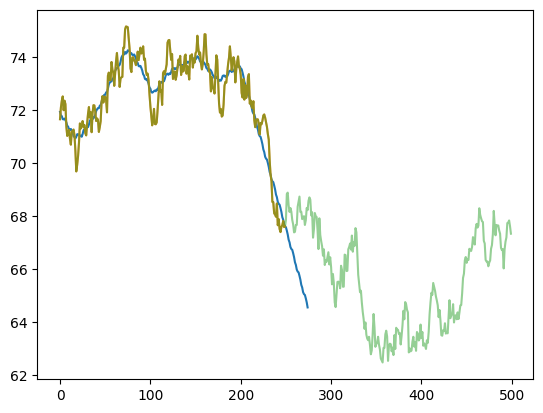

In [9]:
plt.plot(prediction_all[1])
plt.plot(data_to_now_250[1])
plt.plot(full_data[1], alpha=0.5)

In [64]:
import os
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

saving_destination = '.images'
frames = [int(i) for i in np.linspace(10, 470, 46)]
local_data = full_data[['ds', 32]]
local_data.columns = ['ds', 'y']
# funds_data = pd.DataFrame(columns=['ds', 'funds', 'holding', 'current_price'])
ds = []
funds = []
holding = []
stocks_concerned = []
current_price_list = []
status_list = []
current_funds = 10000
current_holding = 0

stock_max = max(local_data['y'])
stock_min = min(local_data['y'])
margin = 0.5

for index, frame in enumerate(frames):
    # Fit the model with the data
    model = Prophet()
    data_available = local_data.iloc[:frame]
    model.fit(data_available)
    future = model.make_future_dataframe(periods=25)
    prediction = model.predict(future)


    # Test implement investing.
    future_price = prediction.iloc[-1]['yhat']
    current_price = prediction.iloc[-26]['yhat']
    if future_price > current_price: # Buying
        status = 'buy'
        stock_buy = int((future_price - current_price) * 5)
        current_funds -= stock_buy*current_price
        current_holding += stock_buy

    elif future_price < current_price: # Selling
        status = 'sell'
        stock_buy = int((current_price - future_price) * 15)
        current_funds += stock_buy*current_price
        current_holding -= stock_buy

        
    # Save the data
    ds.append(prediction.iloc[-1]['ds'])
    funds.append(current_funds)
    holding.append(current_holding)
    current_price_list.append(current_price)
    status_list.append(status)
    stocks_concerned.append(stock_buy)

    
    # Use a context manager to handle the plotting
    with plt.rc_context({'figure.figsize': (10, 6)}):
        plt.figure()
        plt.xlim(0, 500)
        plt.ylim(stock_min - margin, stock_max + margin)
        
        plt.plot(prediction['yhat'], alpha=0.5, label='Prediction')
        plt.plot(prediction['yhat_upper'], alpha=0.5, label='Upper Bound')
        plt.plot(prediction['yhat_lower'], alpha=0.5, label='Lower Bound')
        plt.plot(local_data['y'][:frame+20], alpha=0.5, label='Actual')
        plt.legend()
        
        # Use os.path.join for constructing file paths
        plt.savefig(os.path.join(saving_destination, f'prophet_{frame}.png'))
        plt.close()  # Ensure the current figure is closed

print("starting funds:", 10000)
print("total returns:", current_funds+current_holding*current_price)

19:42:48 - cmdstanpy - INFO - Chain [1] start processing
19:42:48 - cmdstanpy - INFO - Chain [1] done processing
19:42:48 - cmdstanpy - INFO - Chain [1] start processing
19:42:55 - cmdstanpy - INFO - Chain [1] done processing
19:42:55 - cmdstanpy - INFO - Chain [1] start processing
19:42:55 - cmdstanpy - INFO - Chain [1] done processing
19:42:55 - cmdstanpy - INFO - Chain [1] start processing
19:42:56 - cmdstanpy - INFO - Chain [1] done processing
19:42:56 - cmdstanpy - INFO - Chain [1] start processing
19:42:56 - cmdstanpy - INFO - Chain [1] done processing
19:42:56 - cmdstanpy - INFO - Chain [1] start processing
19:42:57 - cmdstanpy - INFO - Chain [1] done processing
19:42:57 - cmdstanpy - INFO - Chain [1] start processing
19:42:57 - cmdstanpy - INFO - Chain [1] done processing
19:42:57 - cmdstanpy - INFO - Chain [1] start processing
19:42:58 - cmdstanpy - INFO - Chain [1] done processing
19:42:58 - cmdstanpy - INFO - Chain [1] start processing
19:42:58 - cmdstanpy - INFO - Chain [1]

starting funds: 10000
total returns: 10031.576703836556


<Axes: >

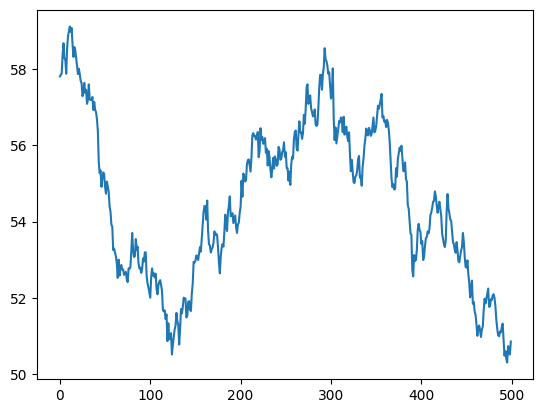

In [62]:
local_data['y'].plot()

In [65]:
process = pd.DataFrame({'ds': ds, 'funds': funds, 'holding': holding, 'current_price': current_price_list, 'status': status_list, 'stocks_concerned': stocks_concerned})
process

,ds,funds,holding,current_price,status,stocks_concerned
0,2023-08-04,6464.649389,60,58.922510,buy,60
1,2023-08-14,6058.159487,67,58.069986,buy,7
2,2023-08-24,6861.401338,53,57.374418,sell,14
3,2023-09-03,7718.068615,38,57.111152,sell,15
4,2023-09-13,11770.169752,-36,54.758123,sell,74
5,2023-09-24,14452.444560,-86,53.645496,sell,50
6,2023-10-04,16910.074151,-133,52.289991,sell,47
7,2023-10-14,16910.074151,-133,52.963219,buy,0
8,2023-10-24,16803.802978,-131,53.135587,buy,2
9,2023-11-04,17643.591847,-147,52.486804,sell,16


ModuleNotFoundError: No module named 'tensorflow'